<div style="text-align: right"> Eric Huang		14781088</div>
<div style="text-align: right"> Mauricio Lomeli 23329506</div>
<div style="text-align: right"> Alexis Chavoya	55614050</div>

## CS 178: Machine Learning & Data Mining: Fall 2020
# Naive Bayes
#### Due Date: , December 11, 2020

<p>For each model, a paragraph or two describing: what features you gave it (raw inputs, selected inputs, non-linear feature expansions, etc.); how was it trained (learning algorithm and software source); and key hyperparameter settings (plus your approach to choosing those settings)</p>


In [127]:
import numpy as np
import mltools as ml
import matplotlib.pyplot as plt
np.random.seed(0)

THRESHHOLD = .9

## Features

These are the features we gave (raw inputs, selected inputs, nonlinear feature expansions, etc.)

In [134]:
X = np.genfromtxt("data/X_train.txt",delimiter=',')
Y = np.genfromtxt("data/Y_train.txt",delimiter=',')
X, Y = ml.shuffleData(X,Y)

print(X.shape)
print(len(X))

X0 = X[Y==0, :]
X1 = X[Y==1, :]

def isContinuous(vect):
    return sum(1 for x in vect if int(x) != x)/len(vect) > THRESHHOLD

def analysis(data, indices=None):
    # Find what features are continuous for X0
    if not indices:
        feature_m  = data[:, :].T
        indices    = [i for i, feature in enumerate(feature_m) if isContinuous(feature)]
    print(indices)

    continuous = data[:, indices].T
    for i, feature in enumerate(continuous):
        # Printing some data
        minimum = np.min(feature)
        maximum = np.max(feature)
        mean    = np.mean(feature)
        stddev  = np.std(feature)
        print(f"\tindex   = {indices[i]} ({i}/{len(indices)})")
        print(f"\tminimum = {minimum}")
        print(f"\tmaximum = {maximum}")
        print(f"\tmean    = {mean}")
        print(f"\tstddev  = {stddev}")

        # Plotting feature
        z = 1
        r = (minimum, maximum) #(max(minimum, mean - z*stddev), min(maximum, mean + z*stddev))
        b = 50
        counts, bins = np.histogram(feature, b, r)
        plt.hist(bins[:-1], bins, weights=counts)
        plt.show()
    return indices

(7423, 107)
7423


[7, 11, 18]
	index   = 7 (0/3)
	minimum = -46.8
	maximum = 5158.56
	mean    = 227.4208608742004
	stddev  = 133.28979038798735


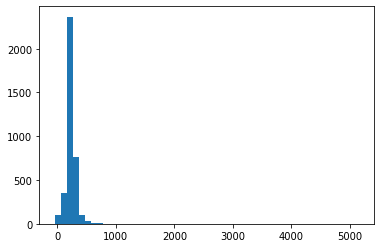

	index   = 11 (1/3)
	minimum = 0.0
	maximum = 7.0
	mean    = 3.5014392324093815
	stddev  = 2.0301840792305095


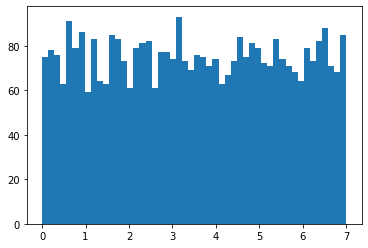

	index   = 18 (2/3)
	minimum = 0.0
	maximum = 1700883.0
	mean    = 100773.228195629
	stddev  = 101736.23273456427


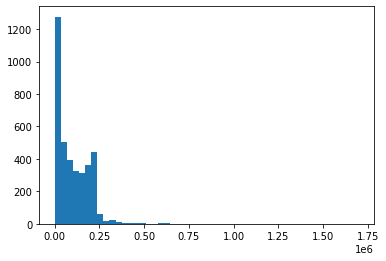

In [129]:
indices0 = analysis(X0)

[11, 18]
	index   = 11 (0/2)
	minimum = 0.01
	maximum = 7.0
	mean    = 3.5209098338327425
	stddev  = 2.0191439912524283


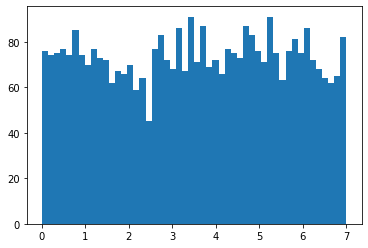

	index   = 18 (1/2)
	minimum = 0.0
	maximum = 1271328.0
	mean    = 96605.65107327704
	stddev  = 102157.94815457465


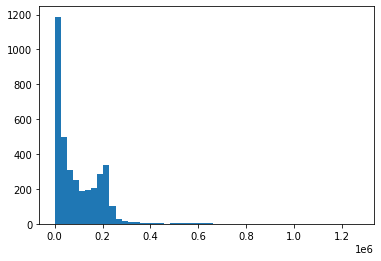

In [130]:
indices1 = analysis(X1)

## Distributions for continuous features

Some of the values that are "continuous" are continuous because of a few non-integer entries. To deal with this, we initialy had a process so that if 90% of the data points are integer valued entries then the data will round them to make them discrete distributions. Upond furthur inspection, this led to only a handful of features that were continuous. Because of this, instead, all data will be rounded to its nearest integer value. 

## Correcting data

In [136]:
X0 = X0.round()
X1 = X1.round()

## Reviewing Continuous Data

[7, 11, 18]
	index   = 7 (0/3)
	minimum = -47.0
	maximum = 5159.0
	mean    = 227.51839019189765
	stddev  = 133.270572535794


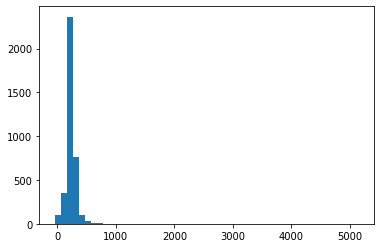

	index   = 11 (1/3)
	minimum = 0.0
	maximum = 7.0
	mean    = 3.5005330490405115
	stddev  = 2.060647561465846


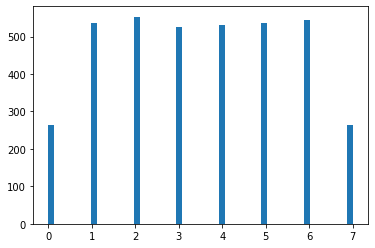

	index   = 18 (2/3)
	minimum = 0.0
	maximum = 1700883.0
	mean    = 100773.22707889126
	stddev  = 101736.2266572239


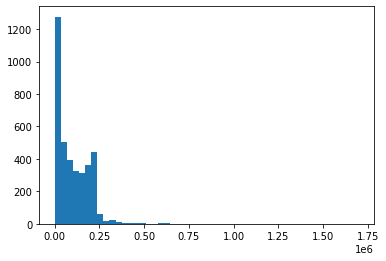

[7, 11, 18]

In [137]:
analysis(X0, indices0)

[11, 18]
	index   = 11 (0/2)
	minimum = 0.0
	maximum = 7.0
	mean    = 3.5170253336965405
	stddev  = 2.057249667956533


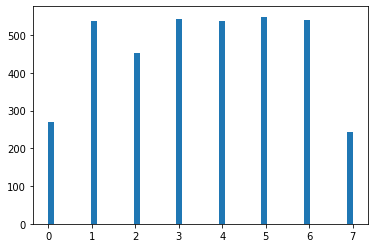

	index   = 18 (1/2)
	minimum = 0.0
	maximum = 1271328.0
	mean    = 96605.65867611005
	stddev  = 102157.94504800015


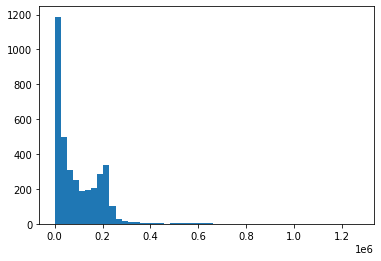

[11, 18]

In [138]:
analysis(X1, indices1)

## Getting Ready for Training

In [140]:
X = X.round()
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y, 0.75)

## Training and Validation

Set up the training and validation data

In [161]:
# Training Data
Xtr0 = Xtr[Ytr == 0, :]
Xtr1 = Xtr[Ytr == 1, :]
P_Y1 = sum(Y)/len(Y)
P_Y0 = 1 - P_Y1

print(f"Prob Y=0: {P_Y0}")
print(f"Prob Y=1: {P_Y1}")

# Validation Data
Xva0 = Xva[Yva == 0, :]
Xva1 = Xva[Yva == 1, :]

Prob Y=0: 0.5054560150882392
Prob Y=1: 0.49454398491176077


In [166]:
XvaGuess = []
for i,row in enumerate(Xva):
    # Calculate P(X|Y=0) and P(X|Y=1)
    p0 = []
    p1 = []
    for j,value in enumerate(row):
        # count every time that value shows up in the Xtr_i for that specific
        # feature, and divide that by the number of data points we searched 
        # through to get the probabilites
        p_0 = sum(1 for k in Xtr0[:, j] if value==k)/Xtr0[:, j].shape[0]
        p_1 = sum(1 for k in Xtr1[:, j] if value==k)/Xtr1[:, j].shape[0]
        
        # if something had probability 0 of occuring, we will have ln(0) which
        # is undefined so we instead just make a random guess to avoid this 
        if p_0 == 0 or p_1 == 0:
            XvaGuess.append(round(np.random.uniform(0, 1)))
            break
        
        # non-zero probabilities, keep them!!
        p0.append(p_0)
        p1.append(p_1)
        
    else:
        # We had no nonzero probabilities, we can safely make a prediction!
        XvaGuess.append(0 if np.log(P_Y0) + sum(np.log(np.array(p0))) > np.log(P_Y1) + sum(np.log(np.array(p1))) else 1)

# Score this approach
XvaGuess = np.array(XvaGuess)
print(f"Accuracy = {sum( (XvaGuess == Yva).astype(int) )/len(Yva)}")

Accuracy = 0.5102370689655172


In [193]:
XvaGuess = []
binaryf = [i for i,feature in enumerate(X.T) if all(j==0 or j==1 for j in feature)]

for i,row in enumerate(Xva):
    p0 = []
    p1 = []
    for j,value in enumerate(binaryf):
        p_0 = sum(1 for k in Xtr0[:, j] if value==k)/Xtr0[:, j].shape[0] + sum(1 for k in Xtr1[:, j] if value!=k)/Xtr1[:, j].shape[0]
        p_1 = sum(1 for k in Xtr1[:, j] if value==k)/Xtr1[:, j].shape[0] + sum(1 for k in Xtr0[:, j] if value!=k)/Xtr0[:, j].shape[0]
        
        if p_0 == 0 or p_1 == 0:
            XvaGuess.append(round(np.random.uniform(0, 1)))
            break
            
        p0.append(p_0)
        p1.append(p_1)
    else:
        XvaGuess.append(0 if np.log(P_Y0) + sum(np.log(np.array(p0))) > np.log(P_Y1) + sum(np.log(np.array(p1))) else 1)
        
XvaGuess = np.array(XvaGuess)
print(f"Accuracy = {sum( (XvaGuess == Yva).astype(int) )/len(Yva)}")

Accuracy = 0.5005387931034483


In [194]:
# THIS DOESNT WORK

# gaus = ml.bayes.gaussClassify(Xtr[:30, :], Ytr[:30])
# XvaGuess = gaus.predictSoft(Xva[:30])
# print(f"Accuracy: {sum((XvaGuess.round() == Yva).astype(int))/len(Yva)}")

## Predictions for Kaggle

In [175]:
# Is result 2 from the records below.

Xte = np.genfromtxt("data/X_test.txt",delimiter=',')
P_Y1 = sum(Y)/len(Y)
P_Y0 = 1 - P_Y1

XteGuess = []
for i,row in enumerate(Xte):
    # Calculate P(X|Y=0) and P(X|Y=1)
    p0 = []
    p1 = []
    for j,value in enumerate(row):
        # count every time that value shows up in the Xtr_i for that specific
        # feature, and divide that by the number of data points we searched 
        # through to get the probabilites
        p_0 = sum(1 for k in X0[:, j] if value==k)/X0[:, j].shape[0]
        p_1 = sum(1 for k in X1[:, j] if value==k)/X1[:, j].shape[0]
        
        # if something had probability 0 of occuring, we will have ln(0) which
        # is undefined so we instead just make a random guess to avoid this 
        if p_0 == 0 or p_1 == 0:
            XteGuess.append(round(np.random.uniform(0, 1)))
            break
        
        # non-zero probabilities, keep them!!
        p0.append(p_0)
        p1.append(p_1)
        
    else:
        # We had no nonzero probabilities, we can safely make a prediction!
        XteGuess.append(0 if np.log(P_Y0) + sum(np.log(np.array(p0))) > np.log(P_Y1) + sum(np.log(np.array(p1))) else 1)

with open("Y_submit.txt", "w") as f:
    f.write("ID,Predicted\n")
    for i,g in enumerate(XteGuess):
        f.write(f"{i}, {g}\n")

## Scores and Log

(1) Score was 0.4994612068965517. This is using all the data and rounding all of the values together. There were some issues with taking the log of something with probability 0. Since this way of guessing has some issues with it, we will not be uploading predictions to Kaggle.

(2) Score was 0.5102370689655172. This time, to avoid this undefined values if anything had probability 0 we would just make a random guess between class 0 and 1 instead of dealing with undefined behavious of log(0). This had a score on kaggle of 0.47851

(3) Score was 0.5005387931034483. This was using only binary valued features. Since it has a lower score than that of the previous attempt, we will not be running it through Kaggle.

(4) Score was unknown since gaussian wont work because of division by 0 error.